--- Iniciando Dataloader ---
Datos cargados: 11 asig, 8 tipos aula, 14 clases, 23 profes.
Total de tareas (horas lectivas) a programar: 448
--- Dataloader Finalizado Correctamente ---
=== Simulated Annealing (nueva versión) ===
Mejor fitness: 0.0189 | Violaciones: 52 | Factible: False


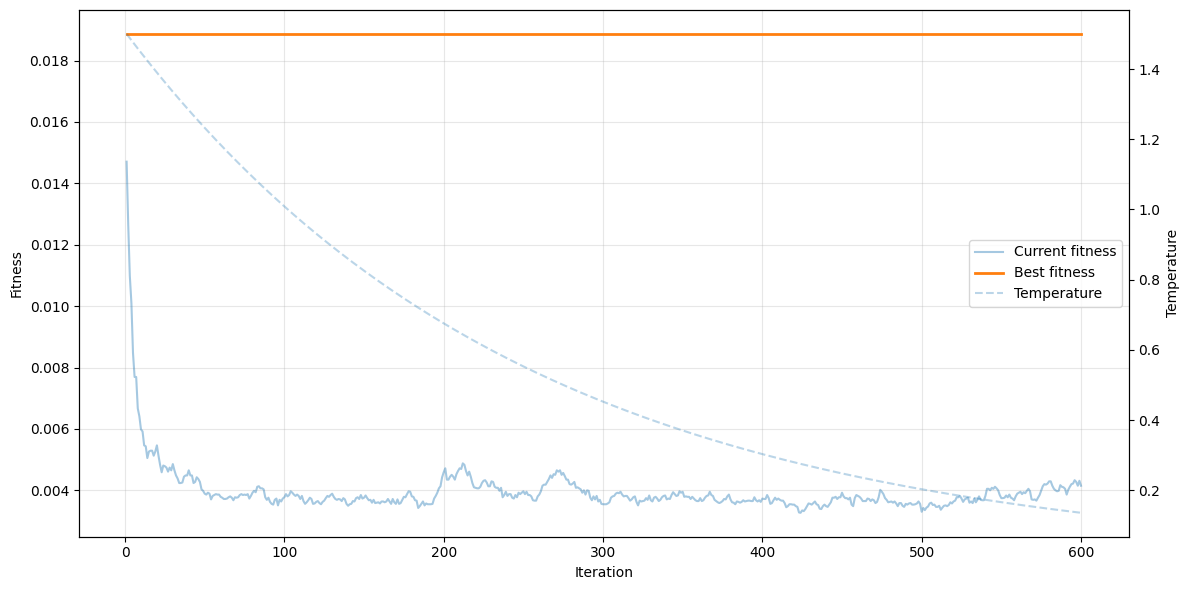

In [4]:
"""Simulated Annealing para el problema de horarios usando los módulos nuevos.

- Carga datos con `cargar_todo_el_sistema`.
- Usa `generar_horario_greedy` / `generar_horario_aleatorio` para generar horarios.
- Usa la mutación de `OptimizadorHorarios` como movimiento local.
- Evalúa con `es_factible` igual que el GA:
    - fitness = 2.0 si es factible
    - fitness = 1 / (1 + violaciones) en caso contrario
- Devuelve el mejor horario, lo guarda en CSV y dibuja una gráfica de convergencia.
"""

from __future__ import annotations

import copy
import math
import random
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === IMPORTS DE TU PROYECTO (ajusta rutas si hace falta) ===
from myutils.dataloader import cargar_todo_el_sistema
from myutils._ga_functions import generar_horario_aleatorio, generar_horario_greedy
from arch.genetic_optimizer import OptimizadorHorarios
from src.factible import es_factible

# Tipo de solución: dict task_id -> (profesor, (día, hora), aula)
Schedule = Dict[str, Tuple[str, Tuple[str, int], str]]

# ---------------------------------------------------------------------------
# Carga de datos y helper del GA para mutaciones
# ---------------------------------------------------------------------------
datos = cargar_todo_el_sistema()
tasks_df = datos["tasks_df"]

# Reutilizamos la mutación avanzada del GA
opt = OptimizadorHorarios(datos, seed=42)


def crear_individuo(prob_aleatorio: float = 0.05) -> Schedule:
    """Genera un horario: 95% greedy, 5% totalmente aleatorio."""
    if random.random() < prob_aleatorio:
        return generar_horario_aleatorio(datos)
    else:
        return generar_horario_greedy(datos, num_intentos=3)


def evaluar_individuo(sol: Schedule) -> Tuple[float, int, bool]:
    """
    Evalúa una solución con el mismo criterio que el GA.

    Devuelve:
    - fitness (float)
    - número de violaciones (int)
    - factible (bool)
    """
    res = es_factible(
        sol,
        datos["tasks_df"],
        datos["prof_subject"],
        datos["prof_max_hours"],
        datos["valid_rooms"],
        datos["rooms_df"],
        datos["Hmax_subject_day"],
        datos["Hmax_prof_day"],
    )

    if res is True:
        return 2.0, 0, True
    else:
        nviol = int(res)
        fitness = 1.0 / (1.0 + nviol)
        return fitness, nviol, False


def mutar_horario(
    sol: Schedule,
    rate_teacher: float = 0.5,
    rate_slot: float = 0.7,
    rate_room: float = 0.5,
    max_conflict_tasks: int = 12,
    max_tries: int = 6,
    random_mut_prob: float = 0.02,
) -> Schedule:
    """Aplica la mutación del GA sobre la solución (in place) y la devuelve."""
    opt.mutar_horario(
        sol,
        rate_teacher=rate_teacher,
        rate_slot=rate_slot,
        rate_room=rate_room,
        max_conflict_tasks=max_conflict_tasks,
        max_tries=max_tries,
        random_mut_prob=random_mut_prob,
    )
    return sol


def mejor_de_poblacion_dirigida(n: int = 80) -> Schedule:
    """Genera n soluciones iniciales y devuelve la mejor según fitness."""
    candidatos: List[Schedule] = [crear_individuo() for _ in range(n)]
    mejor = None
    mejor_fit = -1e9
    mejor_viol = 10**9

    for sol in candidatos:
        fit, viol, _ = evaluar_individuo(sol)
        if (fit > mejor_fit) or (fit == mejor_fit and viol < mejor_viol):
            mejor_fit, mejor_viol = fit, viol
            mejor = sol

    return copy.deepcopy(mejor)


def simulated_annealing(
    iteraciones: int = 3000,
    temp_inicial: float = 1.5,
    alpha: float = 0.996,
    no_mejora_stop: int = 600,
) -> Tuple[Schedule, List[Dict[str, float]]]:
    """
    Ejecuta SA maximizando el fitness. Devuelve el mejor horario y el historial.
    """
    actual = mejor_de_poblacion_dirigida(n=100)
    fit_act, viol_act, _ = evaluar_individuo(actual)
    mejor = copy.deepcopy(actual)
    mejor_fit, mejor_viol = fit_act, viol_act

    temperatura = temp_inicial
    sin_mejora = 0
    historial: List[Dict[str, float]] = []

    for it in range(1, iteraciones + 1):
        # 1) Vecino por mutación
        candidato = copy.deepcopy(actual)
        mutar_horario(candidato)
        fit_new, viol_new, _ = evaluar_individuo(candidato)

        # 2) Criterio de aceptación (Metropolis)
        acepta = False
        if fit_new >= fit_act:
            acepta = True
        else:
            delta = fit_new - fit_act  # negativo
            prob = math.exp(delta / max(temperatura, 1e-8))
            if random.random() < prob:
                acepta = True

        if acepta:
            actual = candidato
            fit_act = fit_new
            viol_act = viol_new

        # 3) Actualizar mejor global
        if (fit_act > mejor_fit) or (fit_act == mejor_fit and viol_act < mejor_viol):
            mejor = copy.deepcopy(actual)
            mejor_fit, mejor_viol = fit_act, viol_act
            sin_mejora = 0
        else:
            sin_mejora += 1

        # 4) Guardar historial
        historial.append(
            {
                "iter": it,
                "fit_actual": fit_act,
                "viol_actual": viol_act,
                "fit_mejor": mejor_fit,
                "viol_mejor": mejor_viol,
                "temperatura": temperatura,
            }
        )

        # 5) Enfriar y parar si toca
        temperatura *= alpha
        if mejor_fit >= 2.0 or sin_mejora >= no_mejora_stop:
            break

    return mejor, historial


def schedule_to_df(sol: Schedule) -> pd.DataFrame:
    """Convierte el diccionario sol -> DataFrame legible para inspección/CSV."""
    rows: List[Dict[str, object]] = []
    for t_id, (prof, (day, period), room) in sol.items():
        row = tasks_df.loc[t_id]
        rows.append(
            {
                "task_id": t_id,
                "group": row["group"],
                "subject": row["subject"],
                "professor": prof,
                "day": day,
                "period": period,
                "room": room,
            }
        )
    return pd.DataFrame(rows)


def guardar_mejor(sol: Schedule, nombre: str = "sa_mejor_horario.csv") -> None:
    """Guarda el mejor horario en CSV."""
    df = schedule_to_df(sol)
    df.to_csv(nombre, index=False, encoding="utf-8-sig")
    print(f"Horario guardado en {nombre} ({len(df)} filas).")


def plot_historial(historial: List[Dict[str, float]]) -> None:
    """Gráfica fitness (actual y mejor) + temperatura."""
    if not historial:
        return

    iters = [h["iter"] for h in historial]
    fit_act = [h["fit_actual"] for h in historial]
    fit_best = [h["fit_mejor"] for h in historial]
    temps = [h["temperatura"] for h in historial]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(iters, fit_act, alpha=0.4, label="Current fitness")
    ax1.plot(iters, fit_best, linewidth=2, label="Best fitness")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Fitness")
    ax1.grid(alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(iters, temps, alpha=0.3, linestyle="--", label="Temperature")
    ax2.set_ylabel("Temperature")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best")

    plt.tight_layout()
    plt.show()


def main() -> None:
    print("=== Simulated Annealing (nueva versión) ===")
    mejor, hist = simulated_annealing(
        iteraciones=3000,
        temp_inicial=1.5,
        alpha=0.996,
        no_mejora_stop=600,
    )
    mejor_fit, mejor_viol, factible = evaluar_individuo(mejor)
    print(f"Mejor fitness: {mejor_fit:.4f} | Violaciones: {mejor_viol} | Factible: {factible}")

    plot_historial(hist)


if __name__ == "__main__":
    main()


=== Tabu Search (nueva versión) ===
Iteration 1 | Current fit: 0.0179 | Current viol: 55 | Best fit: 0.0179 | Best viol: 55 | Tabu size: 1
Iteration 2 | Current fit: 0.0189 | Current viol: 52 | Best fit: 0.0189 | Best viol: 52 | Tabu size: 2
Iteration 3 | Current fit: 0.0169 | Current viol: 58 | Best fit: 0.0189 | Best viol: 52 | Tabu size: 3
Iteration 4 | Current fit: 0.0172 | Current viol: 57 | Best fit: 0.0189 | Best viol: 52 | Tabu size: 4
Iteration 5 | Current fit: 0.0169 | Current viol: 58 | Best fit: 0.0189 | Best viol: 52 | Tabu size: 5
Iteration 6 | Current fit: 0.0164 | Current viol: 60 | Best fit: 0.0189 | Best viol: 52 | Tabu size: 6
Iteration 7 | Current fit: 0.0159 | Current viol: 62 | Best fit: 0.0189 | Best viol: 52 | Tabu size: 7
Iteration 8 | Current fit: 0.0154 | Current viol: 64 | Best fit: 0.0189 | Best viol: 52 | Tabu size: 8
Iteration 9 | Current fit: 0.0149 | Current viol: 66 | Best fit: 0.0189 | Best viol: 52 | Tabu size: 9
Iteration 10 | Current fit: 0.0141 | 

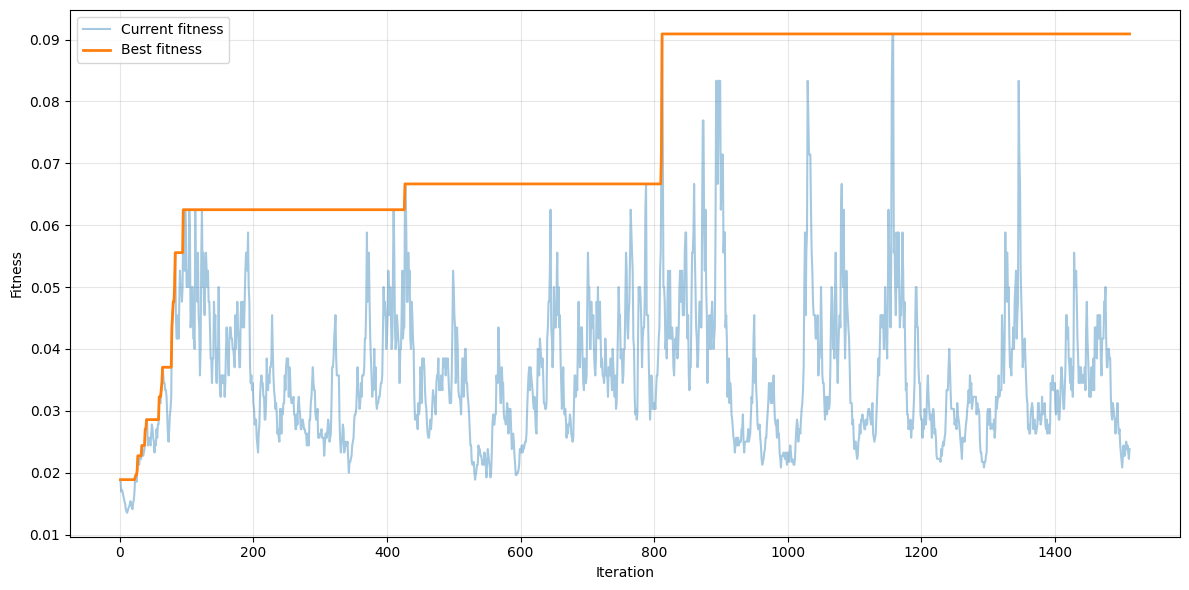

In [8]:
"""Tabu Search para el problema de horarios usando los mismos bloques que SA.

- Soluciones = diccionario {task_id: (prof, (día, hora), aula)}
- Vecindario = aplicar la mutación del GA sobre la solución actual.
- Lista Tabu = hash estable de la solución.
"""

from __future__ import annotations

import copy
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import pandas as pd

# Se reutilizan:
#   - Schedule
#   - datos, tasks_df
#   - crear_individuo, evaluar_individuo, mutar_horario
#   - mejor_de_poblacion_dirigida
#   - guardar_mejor

Schedule = Dict[str, Tuple[str, Tuple[str, int], str]]


def hash_sol(sol: Schedule) -> int:
    """Hash estable de la solución para lista Tabu."""
    return hash(tuple(sorted(sol.items())))


def generar_vecinos(base_sol: Schedule, n_vecinos: int = 25) -> List[Schedule]:
    """Genera vecinos aplicando la mutación (versión suave)."""
    vecinos: List[Schedule] = []
    for _ in range(n_vecinos):
        cand = copy.deepcopy(base_sol)
        mutar_horario(
            cand,
            max_conflict_tasks=12,
            random_mut_prob=0.02,
        )
        vecinos.append(cand)
    return vecinos

def plot_historial_tabu(historial: List[Dict[str, float]]) -> None:
    """Gráfica de convergencia para Tabu Search."""
    if not historial:
        return

    iters = [h["iter"] for h in historial]
    fit_act = [h["fit_actual"] for h in historial]
    fit_best = [h["fit_mejor"] for h in historial]
    viol_act = [h["viol_actual"] for h in historial]
    viol_best = [h["viol_mejor"] for h in historial]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(iters, fit_act, alpha=0.4, label="Current fitness")
    ax1.plot(iters, fit_best, linewidth=2, label="Best fitness")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Fitness")
    ax1.grid(alpha=0.3)


    lines, labels = ax1.get_legend_handles_labels()
    ax1.legend(lines, labels, loc="best")

    plt.tight_layout()
    plt.show()
    


def tabu_search(
    iteraciones: int = 2000,
    tam_tabu: int = 60,
    n_vecinos: int = 30,
    sin_mejora_stop: int = 500,
) -> Tuple[Schedule, List[Dict[str, float]]]:
    """
    Ejecuta Tabu Search. Devuelve mejor solución y el historial de métricas.
    """
    actual = mejor_de_poblacion_dirigida(n=120)
    fit_act, viol_act, _ = evaluar_individuo(actual)
    mejor = copy.deepcopy(actual)
    mejor_fit, mejor_viol = fit_act, viol_act

    tabu_list: List[int] = [hash_sol(actual)]
    historial: List[Dict[str, float]] = []
    sin_mejora = 0

    for it in range(1, iteraciones + 1):
        print(f"Iteration {it} | Current fit: {fit_act:.4f} | Current viol: {viol_act} | Best fit: {mejor_fit:.4f} | Best viol: {mejor_viol} | Tabu size: {len(tabu_list)}")
        vecinos = generar_vecinos(actual, n_vecinos=n_vecinos)

        best_neighbor = None
        best_fit = -1e9
        best_viol = 10**9
        best_hash = None

        for cand in vecinos:
            h = hash_sol(cand)
            if h in tabu_list:
                continue

            fit_new, viol_new, _ = evaluar_individuo(cand)
            if (fit_new > best_fit) or (fit_new == best_fit and viol_new < best_viol):
                best_neighbor = cand
                best_fit = fit_new
                best_viol = viol_new
                best_hash = h

        if best_neighbor is None:
            # No hay vecino fuera de Tabu → relajamos un poco la lista
            if tabu_list:
                tabu_list.pop(0)
            continue

        actual = best_neighbor
        fit_act = best_fit
        viol_act = best_viol

        if (fit_act > mejor_fit) or (fit_act == mejor_fit and viol_act < mejor_viol):
            mejor = copy.deepcopy(actual)
            mejor_fit, mejor_viol = fit_act, viol_act
            sin_mejora = 0
        else:
            sin_mejora += 1

        tabu_list.append(best_hash)
        if len(tabu_list) > tam_tabu:
            tabu_list.pop(0)

        historial.append(
            {
                "iter": it,
                "fit_actual": fit_act,
                "viol_actual": viol_act,
                "fit_mejor": mejor_fit,
                "viol_mejor": mejor_viol,
            }
        )

        if mejor_fit >= 2.0 or sin_mejora >= sin_mejora_stop:
            break

    return mejor, historial





def main() -> None:
    print("=== Tabu Search (nueva versión) ===")
    mejor, hist = tabu_search(
        iteraciones=2500,
        tam_tabu=80,
        n_vecinos=35,
        sin_mejora_stop=700,
    )
    mejor_fit, mejor_viol, factible = evaluar_individuo(mejor)
    print(f"Best fitness: {mejor_fit:.4f} | Violations: {mejor_viol} | Feasible: {factible}")
    plot_historial_tabu(hist)




if __name__ == "__main__":
    main()
